In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import h5py
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats.stats import pearsonr
from scipy.stats import zscore
from matplotlib.pyplot import imshow
import os
import seaborn as sns
from scipy import io
%matplotlib inline
np.set_printoptions(precision=4, suppress=True)


/Users/christinamerrick/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
def columnwise_correlation(ypred, y, zscorea=True, zscoreb=True, axis=0):
    r'''Compute correlations efficiently
    Examples
    --------
    >>> x = np.random.randn(100,2)
    >>> y = np.random.randn(100,2)
    >>> cc = columnwise_correlation(x, y)
    >>> cc.shape
    (2,)
    >>> c1 = np.corrcoef(x[:,0], y[:,0])[0,1]
    >>> c2 = np.corrcoef(x[:,1], y[:,1])[0,1]
    >>> assert np.allclose(cc, np.r_[c1, c2])
    Notes
    -----
    Recall that the correlation cofficient is defined as
    .. math::
       \rho_{x, y} = \frac{cov(X,Y)}{var(x)var(y)}
    Since it is scale invariant, we can zscore and get the same
    .. math::
       \rho_{x, y} = \rho_{zscore(x), zscore(y)} = \frac{cov(X,Y)}{1*1} =
       \frac{1}{N}\frac{\sum_i^n \left(x_i - 0 \right) \left(y_i - 0 \right)}{1*1} =
       \frac{1}{N}\sum_i^n \left(x_i * y_i \right)
    '''
    if zscorea:
        y = zscore(y, axis=axis)
    if zscoreb:
        ypred = zscore(ypred, axis=axis)
    corr = (y * ypred).mean(axis=axis)
    return corr

In [7]:
def cpickle_load(flname, field=None):
    '''
    Load a pickle storing a dictioanry of data
    '''
    import cPickle
    with open(flname, 'r') as fl:
        data = cPickle.load(fl)
        if isinstance(data, list):
            pass
        elif len(data.keys()) == 1:
            data = data[data.keys()[0]]
        elif field is not None:
            data = data[field]
    return data


In [8]:
def cpickle_dump(flname, datadict):
    '''
    Dump a dictionary containing some datas into a pickle file
    '''
    import cPickle
    assert isinstance(datadict, dict)
    print 'Saving %s...' % flname
    fl = open(flname, 'w')
    cPickle.dump(datadict, fl)
    fl.close()
    return

In [13]:
# Load in neural features

pat_id = 'L1'

# change directory to locate hfb for specified patient 
filepath = '/home/knight/cmerrick/notebooks_regression/mat_files/{}/hfb_z.mat'.format(pat_id)
neural_mat = {}

with h5py.File(filepath,'r') as f:
    for k, v in f.items():
        neural_mat[k] = np.array(v, dtype = np.float32)


hfb = neural_mat['hfb_lp']

hfb = hfb.T

IOError: Unable to open file (unable to open file: name = '/home/knight/cmerrick/notebooks_regression/mat_files/L1/hfb_z.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# load reconstructed kinematics 
filepath = '/home/knight/cmerrick/notebooks_regression/mat_files/{}/total_kin.mat'
clean_move = {}
f = h5py.File(filepath,'r')
for k, v in f.items():
    clean_move[k] = np.array(v)

In [ ]:
clean_move = np.squeeze(clean_move['total_kin_mat'])

In [ ]:
## adding time lags to the kinematic data : 200 lags before movement onset and 200 lags after
num_kin_lags = 400
num_kin_feat = 7
num_samples = clean_move.shape[0]

kin_lags = np.zeros((num_kin_feat,num_kin_lags,num_samples))
clean_move_padded = np.vstack([np.zeros([200,7]),clean_move[:-200,:]])

for kin_feat in range(num_kin_feat):
    for lag in range(num_kin_lags):
        print lag
        kin_lags[kin_feat,lag,:] = np.hstack([clean_move_padded[400-lag:,kin_feat],np.zeros(400-lag)])


In [183]:
# reshape kinematic features
# resulting matrix = time X all time-lagged features (800)

kin_feat = np.reshape(kin_lags,(kin_lags.shape[0]*kin_lags.shape[1],kin_lags.shape[2]))
kin_feat = kin_feat.T

In [90]:
kin_feat.shape

(154651, 800)

In [14]:
# Getting the right indcies for ipsi and contra arm

if pat_id == 'L1':
    
    ipsi_ind = range(0,57117)
    contra_ind = np.hstack(range(57117,114409))
    
elif pat_id == 'L2':
    ipsi_ind = np.hstack((range(5000,37000), range(37000,55000),range(58000,69685)))
    contra_ind = np.hstack((range(72800,101000), range(115800,147397)))
    
elif pat_id == 'L3':
    ipsi_ind = range(0,67138)
    contra_ind = range(67139,133084)

elif pat_id == 'R4':
    ipsi_ind = np.hstack(range(63831,127331)) 
    contra_ind = range(0,63500)
    
elif pat_id == 'R5':
    ipsi_ind = np.hstack((range(79900,110000),range(115000,140157)))
    contra_ind = np.hstack((range(5000,32000),range(37000,72000)))  
    
elif pat_id == 'R6':
    contra_ind = np.hstack((range(500,23000),range(26000,49700))) 
    ipsi_ind = np.hstack((range(51500,72500),range(75500,78000),range(79000,99500))) 


In [188]:
crosscorr = np.dot(zscore(kin_feat).T, zscore(kin_feat))/kin_feat.shape[0]

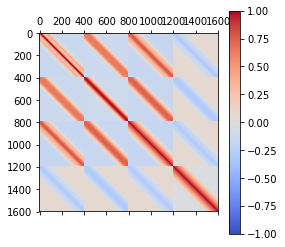

In [189]:
plt.matshow((crosscorr),
            vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar()

In [175]:
neural_feat = hfb

In [177]:
print kin_feat.shape
print neural_feat.shape

(154651, 800)
(154651, 87)


In [190]:
## for testing ipsi and contra within hand ##

# lamdbas for ridge 
l = np.logspace(0,8, num = 20)
num_elec = neural_feat.shape[1]
num_hands = 2

# number of mutually exclusive test sets (each comprising of 20% of the data)
num_test_set = 5
test_set_run = [[0,1,2,3,4],[1,2,3,4,0],[2,3,4,0,1],[3,4,0,1,2],[4,0,1,2,3]]

# number of mutually exclusive validation sets within the estimation set (80% training, 20% validation)
num_val_fold = 5
val_fold_run = [[0,1,2,3,4],[1,2,3,4,0],[2,3,4,0,1],[3,4,0,1,2],[4,0,1,2,3]]

### correlation coefficient across folds and test sets ###
cc_test = np.zeros((num_hands,num_test_set,num_elec))

## to hold prediction test sets
prediction_test = {}
ecog_test = {}
feat_test = {}
feat_test_angle = {}
weights_reg = {}


for hand in range(num_hands):

    # init 
    neural_mat = []
    kin_mat = []
    cc_val = np.zeros((num_test_set,num_val_fold,len(l),num_elec))

    if hand == 0:

        neural_mat = neural_feat[ipsi_ind,:]
        kin_mat = kin_feat[ipsi_ind,:]

    elif hand == 1:

        neural_mat = neural_feat[contra_ind,:]
        kin_mat = kin_feat[contra_ind,:]


    #### CREATING TEST SET ####
    for test_set in range(num_test_set):

        test_run = test_set_run[test_set]

        split_data_feat = np.array_split(kin_mat, num_test_set)
        split_data_ecog = np.array_split(neural_mat, num_test_set)

        ### for features/kinematics ###

        estimate_temp_f = []
        for ind in range(num_test_set-1):
            estimate_temp_f.extend(split_data_feat[test_run[ind]])

        test_temp_f = []
        test_temp_f.extend(split_data_feat[test_run[4]])

        estimate_feat = np.squeeze(estimate_temp_f)
        test_feat = np.squeeze(test_temp_f)

        ### for ecog ###

        estimate_temp_e = []
        for ind in range(num_test_set-1):
            estimate_temp_e.extend(split_data_ecog[test_run[ind]])

        test_temp_e = []
        test_temp_e.extend(split_data_ecog[test_run[4]])

        estimate_ecog = np.squeeze(estimate_temp_e)
        test_ecog = np.squeeze(test_temp_e)


        #### CREATING VALIDATION FOLD ####
        for fold in range(num_val_fold):

            val_fold = val_fold_run[fold]

            estimate_split_feat = np.array_split(estimate_feat, num_val_fold)
            estimate_split_ecog = np.array_split(estimate_ecog, num_val_fold)

            ### for features/kinematics ###

            train_temp_f = []
            for ind in range(num_val_fold-1):
                train_temp_f.extend(estimate_split_feat[val_fold[ind]])

            val_temp_f = []
            val_temp_f.extend(estimate_split_feat[val_fold[4]])

            train_feat = np.squeeze(train_temp_f)
            val_feat = np.squeeze(val_temp_f)

            ### for ecog ###

            train_temp_e = []
            for ind in range(num_val_fold-1):
                train_temp_e.extend(estimate_split_ecog[val_fold[ind]])

            val_temp_e = []
            val_temp_e.extend(estimate_split_ecog[val_fold[4]])

            train_ecog = np.squeeze(train_temp_e)
            val_ecog = np.squeeze(val_temp_e)


            # doing all computation we can outside lambda loop # 
            XTX = np.dot(train_feat.T,train_feat)
            XTY = np.dot(train_feat.T,train_ecog)

            #### ridge regression ####

            # finding best lambda for each validation set
            for param in range(len(l)):
                XTXinv = np.linalg.inv(XTX +l[param]*np.identity(XTX.shape[0]))
                weights = np.dot(XTXinv,XTY)

                # create the prediction for the validation set
                # init
                num_timepnts = val_ecog.shape[0]
                num_elec = val_ecog.shape[1]
                prediction = np.zeros([num_timepnts])

                # record correlation from prediction set
                prediction = np.dot(val_feat,weights)
                mask = prediction[:,0] != 0
                cc_val[test_set,fold,param,:] = columnwise_correlation(prediction[mask,:],val_ecog[mask,:], zscorea=True, zscoreb=True, axis=0)


        # using best lambda to predict held-out test set
        for elec in range(test_ecog.shape[1]):

            max_corr = np.max(np.mean(cc_val[test_set,:,:,elec],0))

            best_lambda = np.squeeze(np.where(np.mean(cc_val[test_set,:,:,elec],0) == max_corr))


            XTXinv = np.linalg.inv(XTX + l[best_lambda]*np.identity(XTX.shape[0]))
            weights_reg[hand,test_set,elec] = np.dot(XTXinv,XTY[:,elec])

            # create the prediction for the test set
            prediction_test[hand,test_set,elec] = np.squeeze(np.sum([test_feat*weights_reg[hand,test_set,elec]],axis = 2))
            ecog_test[hand,test_set,elec] = test_ecog[:,elec]

            # record correlation from prediction set
            mask = prediction_test[hand,test_set,elec] != 0
            cc_test[hand,test_set,elec] = columnwise_correlation(prediction_test[hand,test_set,elec][mask],ecog_test[hand,test_set,elec][mask], zscorea=True, zscoreb=True, axis=0) 


In [200]:
## for testing ipsi and contra across hands ##
    # specifically training on ipsi and testing on contra #

num_elec = neural_feat.shape[1]

# number of mutually exclusive test sets (each comprising of 20% of the data)
num_test_set = 5
test_set_run = [[0,1,2,3,4],[1,2,3,4,0],[2,3,4,0,1],[3,4,0,1,2],[4,0,1,2,3]]

### correlation coefficient across folds and test sets ###
cc_test_gen = np.zeros((num_test_set,num_elec))

## to hold prediction test sets
prediction_test_gen = {}
ecog_test_gen = {}

# init 
neural_mat = []
kin_mat = []

# getting data when contra hand is moving
neural_mat = neural_feat[contra_ind,:]
kin_mat = kin_feat[contra_ind,:]


#### CREATING TEST SET ####
for test_set in range(num_test_set):

    test_run = test_set_run[test_set]
    split_data_ecog = np.array_split(neural_mat, num_test_set)
    split_data_feat = np.array_split(kin_mat, num_test_set)

    ### for features/kinematics ###
    test_temp_f = []
    test_temp_f.extend(split_data_feat[test_run[4]])

    test_feat = np.squeeze(test_temp_f)

    ### for ecog ###
    test_temp_e = []
    test_temp_e.extend(split_data_ecog[test_run[4]])

    test_ecog = np.squeeze(test_temp_e)


   # using previously saved ipsi weights to predict contra
    for elec in range(test_ecog.shape[1]):

        # loading the weights 
        weights = weights_reg[0,test_set,elec]

        # create the prediction for the test set
        prediction_test_gen[test_set,elec] = np.squeeze(np.sum([test_feat*weights],axis = 2))
        ecog_test_gen[test_set,elec] = test_ecog[:,elec]

        # record correlation from prediction set
        mask = prediction_test_gen[test_set,elec] != 0
        cc_test_gen[test_set,elec] = columnwise_correlation(prediction_test_gen[test_set,elec][mask],test_ecog[mask,elec], zscorea=True, zscoreb=True, axis=0)



In [202]:
## for testing ipsi and contra across hands ##
    # specifically training on contra and testing on ipsi #

num_elec = neural_feat.shape[1]

# number of mutually exclusive test sets (each comprising of 20% of the data)
num_test_set = 5
test_set_run = [[0,1,2,3,4],[1,2,3,4,0],[2,3,4,0,1],[3,4,0,1,2],[4,0,1,2,3]]

### correlation coefficient across folds and test sets ###
cc_test_gen_2 = np.zeros((num_test_set,num_elec))

## to hold prediction test sets
prediction_test_gen_2 = {}
ecog_test_gen_2 = {}


# init 
neural_mat = []
kin_mat = []

# getting data when contra hand is moving
neural_mat = neural_feat[ipsi_ind,:]
kin_mat = kin_feat[ipsi_ind,:]


#### CREATING TEST SET ####
for test_set in range(num_test_set):

    test_run = test_set_run[test_set]
    split_data_ecog = np.array_split(neural_mat, num_test_set)
    split_data_feat = np.array_split(kin_mat, num_test_set)

    ### for features/kinematics ###
    test_temp_f = []
    test_temp_f.extend(split_data_feat[test_run[4]])

    test_feat = np.squeeze(test_temp_f)

    ### for ecog ###
    test_temp_e = []
    test_temp_e.extend(split_data_ecog[test_run[4]])

    test_ecog = np.squeeze(test_temp_e)


   # using previously saved ipsi weights to predict contra
    for elec in range(test_ecog.shape[1]):

        # loading the weights (for contra hand)
        weights = weights_reg[1,test_set,elec]

        # create the prediction for the test set
        prediction_test_gen_2[test_set,elec] = np.squeeze(np.sum([test_feat*weights],axis = 2))
        ecog_test_gen_2[test_set,elec] = test_ecog[:,elec]

        # record correlation from prediction set
        mask = prediction_test_gen_2[test_set,elec] != 0
        cc_test_gen_2[test_set,elec] = columnwise_correlation(prediction_test_gen_2[test_set,elec][mask],ecog_test_gen_2[test_set,elec][mask], zscorea=True, zscoreb=True, axis=0)

            


In [204]:
## putting all test sets together for hfb ##
num_elec = neural_feat.shape[1]
num_test_set = 5
num_hand = 2
avg_cc = np.zeros((num_hand,num_test_set,num_elec))

for hand in range(num_hand):        
        for test_set in range(num_test_set):

            for elec in range(num_elec):

                avg_cc[hand,test_set,elec] = cc_test[hand,test_set,elec]

In [205]:
## Make dictionary to save our vars ##
os.chdir('/home/knight/cmerrick/notebooks_regression/model_outputs_kin/{}'.format(pat_id))

kin_dict = {}

kin_dict = {'prediction_test_gen':prediction_test_gen, 'prediction_test_gen_2':prediction_test_gen_2,
            'cc_test_gen':cc_test_gen, 'cc_test_gen_2':cc_test_gen_2, 'cc_test':cc_test, 
            'ecog_test':ecog_test, 'prediction_test':prediction_test,'feat_test':feat_test}

kin_file_name = 'full_encoding_model'
cpickle_dump(kin_file_name, kin_dict)

Saving pz_sp_theta_phi...
